In [6]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; float:center}</style>")

In [7]:
from __future__ import division, print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import textblob as tb
from textblob import TextBlob
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer



%matplotlib inline

sns.set_context('notebook', font_scale=1.5)
sns.set_style('ticks')

punctuation = ['.',',',':','!',';','-','?','"',"'",'(',')','—']   
other = ['ive','ve', "i've", "i'v", 'i’ll', 'i’ve', 'i’v']  # 'deb','hideb','don','didn','twaittry','doesn','thank','heydeb',
mystops = stopwords.words('english') + punctuation + other


In [8]:
comments_classified = pd.read_csv('comments_classified_SK_filtered2000_additional.csv',index_col=0)

comments_with_sentences_100 = pd.read_csv('comments_with_sentences_100.csv',index_col=0)
comments_only_100 = pd.read_csv('comments_only_100.csv',index_col=0)

comments_with_sentences_all = pd.read_csv('comments_with_sentences_all.csv',index_col=0)
comments_only_all = pd.read_csv('comments_only_all.csv',index_col=0)

In [9]:
recipes = pd.read_csv('/Users/kateliea/Documents/Insight/project/webscrapers/recipes_smittenkitchen_100.csv', index_col=0)

In [10]:
print('total comments %i;  total sentences, %i' % (comments_only_all.shape[0], comments_with_sentences_all.shape[0]))

total comments 227809;  total sentences, 802691


In [11]:
recipes['recipe_ID'] = recipes.index

# recipes['recipe_ID'] = recipes['recipe_ID'].apply(lambda x: 'R'+str(x))

In [12]:
comments_classified.columns

Index(['category', 'sentence', 'commentID', 'child_id', 'children',
       'comment_time', 'recipenumber', 'title', 'url', 'usercomment',
       'username', 'usersite', 'usercomment_lower', 'tokens', 'tokens_stemmed',
       'sentence_bigrams', 'sentence_trigrams', 'sentence_tokens',
       'sentence_tokens_stemmed', 'category_label'],
      dtype='object')

In [13]:
def comment_sentiment(comment): 
    comment = tb.TextBlob(comment)
    return comment.sentiment.polarity

In [14]:
comments_with_sentences_100['sentiment_polarity_comment'] = comments_with_sentences_100.usercomment.apply(comment_sentiment)
comments_with_sentences_100['sentiment_polarity_sentence'] = comments_with_sentences_100.sentence.apply(comment_sentiment)

exploratory analysis of TextBlob

Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.m

In [15]:
txt = tb.TextBlob(comments_classified.usercomment[130])
txt

TextBlob("I am so making this next week-end. I agree with you about lemon and here’s a suggestion that I am going to do when I bake this pie: move the lemon flavor to the crust. Just zest the lemon in the dough while pulsing the butter and flour. i think it should give that lemony edge without intercepting anything in the filling!")

In [16]:
txt.tags, txt.noun_phrases

([('I', 'PRP'),
  ('am', 'VBP'),
  ('so', 'RB'),
  ('making', 'VBG'),
  ('this', 'DT'),
  ('next', 'JJ'),
  ('week-end', 'NN'),
  ('I', 'PRP'),
  ('agree', 'VBP'),
  ('with', 'IN'),
  ('you', 'PRP'),
  ('about', 'IN'),
  ('lemon', 'NN'),
  ('and', 'CC'),
  ('here’s', 'VB'),
  ('a', 'DT'),
  ('suggestion', 'NN'),
  ('that', 'IN'),
  ('I', 'PRP'),
  ('am', 'VBP'),
  ('going', 'VBG'),
  ('to', 'TO'),
  ('do', 'VB'),
  ('when', 'WRB'),
  ('I', 'PRP'),
  ('bake', 'VBP'),
  ('this', 'DT'),
  ('pie', 'NN'),
  ('move', 'VB'),
  ('the', 'DT'),
  ('lemon', 'NN'),
  ('flavor', 'NN'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('crust', 'NN'),
  ('Just', 'RB'),
  ('zest', 'JJS'),
  ('the', 'DT'),
  ('lemon', 'NN'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('dough', 'NN'),
  ('while', 'IN'),
  ('pulsing', 'VBG'),
  ('the', 'DT'),
  ('butter', 'NN'),
  ('and', 'CC'),
  ('flour', 'NN'),
  ('i', 'NN'),
  ('think', 'VBP'),
  ('it', 'PRP'),
  ('should', 'MD'),
  ('give', 'VB'),
  ('that', 'IN'),
  ('lemony', 'NN'),
 

In [17]:
txt.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [18]:
comments_with_sentences_100[(comments_with_sentences_100.sentiment_polarity_sentence > 0) & (comments_with_sentences_100.title=='best cocoa brownies')].sentiment_polarity_sentence.mean()

0.4595538414182737

calculate positive/negative mean sentiment for recipe

In [19]:
title = recipes.title[2]

positive = 100*comments_with_sentences_100[
    (comments_with_sentences_100.sentiment_polarity_sentence > 0) 
    & (comments_with_sentences_100.title==title)].sentiment_polarity_sentence.mean()
negative = 100*comments_with_sentences_100[
    (comments_with_sentences_100.sentiment_polarity_sentence < 0) 
    & (comments_with_sentences_100.title==title)].sentiment_polarity_sentence.mean()


In [20]:
recipes['numberofcomments'].loc[recipes.title=='best cocoa brownies'].values[0]

993

In [21]:
(positive - negative)*(recipes[recipes.title==title].numberofcomments)

2    3506.751321
Name: numberofcomments, dtype: float64

In [50]:
def happiness_graph(recipe):
    width = 0.2
    lw=0
    fig, ax = plt.subplots()
    
    name = recipe['recipe_title']
    positive = recipe['mean_positivity_sentences']
    negative = recipe['mean_negativity_sentences']
    
    with sns.axes_style({'font.family': [u'sans-serif']}):
        sns.set_context('notebook', font_scale=1.5)
        ax.barh(0, 100*positive, color='orange', linewidth=lw)
        ax.barh(0, 100*negative, color='blue', linewidth=lw)

        ax.set_xlim((-60,60))
        ax.set_yticks(ticks=[])
        ax.set_title('recipe happiness (%)')
        sns.despine(offset=20, trim=True, left=True)
        
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color('white')
        
    plt.savefig('/Users/kateliea/Documents/Insight/project/images/' + name + '.png', transparent=True)
    plt.close()

In [23]:
recipes.columns

Index(['article_id', 'author', 'author_url', 'directions', 'firstimageURL',
       'ingredients', 'introductory_text', 'numberofcomments', 'published',
       'recipe_notes', 'servings', 'time', 'title', 'updated', 'url',
       'recipe_ID'],
      dtype='object')

create a data table with the recipe sentiment, ranked by happiness score 

include name for happiness plot

In [44]:
# recipe_ranks = pd.DataFrame()
recipe_ranks = {}

for i, recipe_title in enumerate(comments_with_sentences_100.title.unique()):
        recipe_sentiment = {}
        
        recipe_sentiment['recipe_title'] = recipe_title

        recipe_sentiment['recipe_ID'] = recipes[recipes.title == recipe_title].recipe_ID.values[0]
        
        recipe_sentiment['numberofcomments'] = recipes[recipes.title == recipe_title].numberofcomments.values[0]
        
        recipe_sentiment['mean_positivity_sentences'] = comments_with_sentences_100[
                    (comments_with_sentences_100.sentiment_polarity_sentence > 0) 
                    & (comments_with_sentences_100.title == recipe_title)].sentiment_polarity_sentence.mean()
        
        recipe_sentiment['mean_positivity_comment'] = comments_with_sentences_100[
                    (comments_with_sentences_100.sentiment_polarity_comment > 0) 
                    & (comments_with_sentences_100.title == recipe_title)].sentiment_polarity_comment.mean()

        recipe_sentiment['mean_negativity_sentences'] = comments_with_sentences_100[
                    (comments_with_sentences_100.sentiment_polarity_sentence < 0) 
                    & (comments_with_sentences_100.title == recipe_title)].sentiment_polarity_sentence.mean()
        
        recipe_sentiment['mean_negativity_comment'] = comments_with_sentences_100[
                    (comments_with_sentences_100.sentiment_polarity_comment < 0) 
                    & (comments_with_sentences_100.title == recipe_title)].sentiment_polarity_comment.mean()
        
        recipe_sentiment['sentence_rank'] = (recipe_sentiment['mean_positivity_sentences'] + recipe_sentiment['mean_negativity_sentences'])*(recipes[recipes.title==recipe_title].numberofcomments.values[0]/recipes.numberofcomments.mean())
        recipe_sentiment['comment_rank'] = (recipe_sentiment['mean_positivity_comment'] + recipe_sentiment['mean_negativity_comment'])*(recipes[recipes.title==recipe_title].numberofcomments.values[0]/recipes.numberofcomments.mean())
        
        recipe_sentiment['plot_name'] = recipe_title + '.jpg'
        
        
        recipe_ranks[i] = recipe_sentiment
               
ranks = pd.DataFrame.from_dict(recipe_ranks,orient='index')

ranks.to_csv('Recipe_sentiment_ranks.csv')

In [51]:
for recipe in recipe_ranks: 
    happiness_graph(recipe_ranks[recipe])

In [26]:
ranks

,mean_negativity_sentences,mean_positivity_comment,plot_name,recipe_title,numberofcomments,sentence_rank,recipe_ID,comment_rank,mean_positivity_sentences,mean_negativity_comment
0,-0.227809,0.320051,sweet potato buttermilk pie.jpg,sweet potato buttermilk pie,259,0.174760,0,0.073021,0.415227,-0.241741
1,-0.222290,0.341266,best cocoa brownies.jpg,best cocoa brownies,993,0.848226,1,0.535390,0.459554,-0.191508
2,-0.323480,0.255622,sav’h.jpg,sav’h,47,0.016778,2,0.032678,0.422637,-0.062500
3,-0.298049,0.330228,classic cobb salad.jpg,classic cobb salad,217,0.113329,3,0.132741,0.443110,-0.160319
4,-0.248137,0.368366,cumin seed roasted cauliflower with yogurt.jpg,cumin seed roasted cauliflower with yogurt,222,0.182365,4,0.184199,0.476307,-0.137902
5,-0.217418,0.262694,chocolate pavlova.jpg,chocolate pavlova,112,0.070291,5,0.039967,0.391740,-0.163575
6,-0.300111,0.367544,homemade merguez with herby yogurt.jpg,homemade merguez with herby yogurt,44,0.028154,6,0.025435,0.477839,-0.206981
7,-0.242268,0.314451,fudgy chocolate sheet cake.jpg,fudgy chocolate sheet cake,327,0.240947,7,0.198771,0.446933,-0.145611
8,-0.207342,0.330390,israeli salad + pita chips.jpg,israeli salad + pita chips,77,0.060714,8,0.067367,0.426355,-0.087379
9,-0.221274,0.317312,failproof crepes + a crepe party.jpg,failproof crepes + a crepe party,157,0.114078,9,0.100213,0.423098,-0.140018


In [27]:
ranks.numberofcomments.max(), ranks.numberofcomments.min(), ranks.numberofcomments.mean()

(1237, 31, 277.76)

In [28]:
ranks.sentence_rank.max(), ranks.sentence_rank.min(), ranks.sentence_rank.mean()

(1.0014616243669396, 0.016778357286231269, 0.2082712382563939)

In [29]:
ranks.comment_rank.max(), ranks.comment_rank.min(), ranks.comment_rank.mean()

(0.86852582425090097, -0.008230820515504382, 0.17752501259600553)

In [58]:
ranks.sort_values('comment_rank').tail(6)

,mean_negativity_sentences,mean_positivity_comment,plot_name,recipe_title,numberofcomments,sentence_rank,recipe_ID,comment_rank,mean_positivity_sentences,mean_negativity_comment
82,-0.258177,0.349250,"how to poach an egg, smitten kitchen-style.jpg","how to poach an egg, smitten kitchen-style",508,0.335601,82,0.427790,0.441674,-0.115346
1,-0.222290,0.341266,best cocoa brownies.jpg,best cocoa brownies,993,0.848226,1,0.535390,0.459554,-0.191508
20,-0.243939,0.320643,tomato sauce with onion and butter.jpg,tomato sauce with onion and butter,848,0.558428,20,0.616788,0.426850,-0.118616
74,-0.224103,0.337030,chocolate peanut butter cake.jpg,chocolate peanut butter cake,1237,1.001462,74,0.776213,0.448975,-0.162737
12,-0.213788,0.368112,red wine chocolate cake.jpg,red wine chocolate cake,842,0.798623,12,0.816769,0.477239,-0.098675
55,-0.227755,0.387276,cinnamon toast french toast + book preview.jpg,cinnamon toast french toast + book preview,937,0.747399,55,0.868526,0.449310,-0.129815


In [35]:
ranks[['recipe_title','sentence_rank']].sort_values('sentence_rank', ascending=False).head(5)

,recipe_title,sentence_rank
74,chocolate peanut butter cake,1.001462
1,best cocoa brownies,0.848226
12,red wine chocolate cake,0.798623
55,cinnamon toast french toast + book preview,0.747399
20,tomato sauce with onion and butter,0.558428


In [32]:
ranks.to_csv('Recipe_sentiment_ranks.csv')

In [33]:
comments_with_sentences_100.loc[comments_with_sentences_100.sentence.str.contains(phrase) == True, 'category'] = 'substitute'

NameError: name 'phrase' is not defined

In [ ]:
phrase = 'reduc'

In [ ]:
comments_with_sentences_100[comments_with_sentences_100.sentence.str.contains(phrase)] # = 'add'

## a dictionary of related words to classify with

In [36]:
subs = ['had trouble','had issue','exchange','recommend','change','easier','gluten free','gluten-free','vegan','vegetarian','easier','replace with','replac','adjust','suggest','swap','switch','instead of','in place of','substitute','replace','i use','to make it','customiz','adjust','instead','exchang','opted to use','better with']

add = ['will ad','will do','next time','going to add','add more','better with','includ','i up','should have ad']

omit = ['omit','leave out','remov','left out','eliminat','add less','forgot','decreas','dispensed with','delet','reduc','should have left out']

In [38]:
len(set(add+subs+omit))

47

In [ ]:
# for _, row in comments_with_sentences_100[:1].iterrows():
#     print(row['usercomment'])
# #     for phrase in subs: 
        
#         if row.usercomment.str.contains(phrase):
#             row.category = 'substitute'

comments_with_sentences_100['category'] = 'other'

for phrase in omit: 
    comments_with_sentences_100.loc[comments_with_sentences_100.sentence.str.contains(phrase) == True, 'category'] = 'omission'
    
for phrase in subs: 
    comments_with_sentences_100.loc[comments_with_sentences_100.sentence.str.contains(phrase) == True, 'category'] = 'substitution'
    
for phrase in add: 
    comments_with_sentences_100.loc[comments_with_sentences_100.sentence.str.contains(phrase) == True, 'category'] = 'addition'
    


In [ ]:
comments_with_sentences_100.loc[comments_with_sentences_100.sentence.str.contains(phrase) == True]

In [ ]:
print('other, %i; additions, %i; substitutions, %i; omissions, %i' % (comments_with_sentences_100[comments_with_sentences_100.category == 'other'].sentence.count(), comments_with_sentences_100[comments_with_sentences_100.category == 'addition'].sentence.count(), comments_with_sentences_100[comments_with_sentences_100.category == 'substitution'].sentence.count(), comments_with_sentences_100[comments_with_sentences_100.category == 'omission'].sentence.count()))

In [52]:
comments_with_sentences_100.shape

(97316, 18)

In [ ]:
comments_with_sentences_100.to_csv('comments_with_sentences_100_classified_4classes.csv')

In [54]:
recipe_ranks = pd.read_csv('Recipe_sentiment_ranks.csv')
recipe_ranks.columns

Index(['Unnamed: 0', 'mean_negativity_sentences', 'mean_positivity_comment',
       'plot_name', 'recipe_title', 'numberofcomments', 'sentence_rank',
       'recipe_ID', 'comment_rank', 'mean_positivity_sentences',
       'mean_negativity_comment'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128cbe588>]], dtype=object)

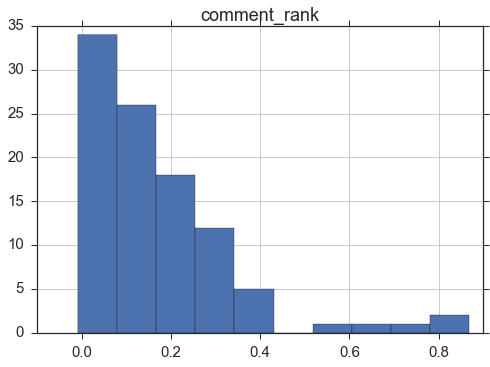

In [56]:
recipe_ranks.hist('comment_rank')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118445f28>]], dtype=object)

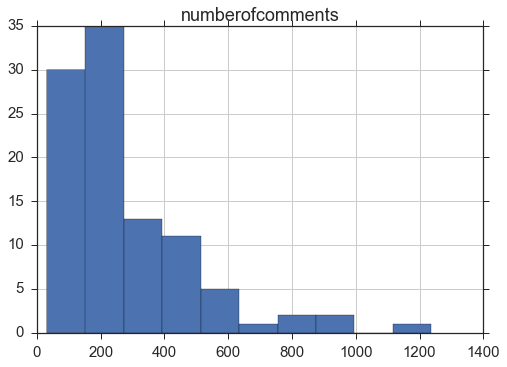

In [59]:
recipe_ranks.hist('numberofcomments')